# **Marketing Performance Intelligence & Revenue Prediction**

**### **### **De la donnée brute aux décisions stratégiques : KPI, machine learning et segmentation des campagnes pour maximiser le ROI.******

Ce notebook transforme les données marketing en leviers de décision et de croissance

In [3]:
from pyspark.sql import functions as F

StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 5, Finished, Available, Finished)

In [4]:
# Charger la table du Lakehouse dans un Spark DataFrame
df = spark.table("marketing_clean")

# Vérifier rapidement la structure
df.printSchema()

# Afficher quelques lignes
display(df.limit(5))


StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 6, Finished, Available, Finished)

root
 |-- id: integer (nullable = true)
 |-- c_date: date (nullable = true)
 |-- campaign_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- campaign_id: integer (nullable = true)
 |-- impressions: integer (nullable = true)
 |-- mark_spent: double (nullable = true)
 |-- clicks: integer (nullable = true)
 |-- leads: integer (nullable = true)
 |-- orders: integer (nullable = true)
 |-- revenue: double (nullable = true)



SynapseWidget(Synapse.DataFrame, c25fb87f-d612-468e-8fb7-5c88b2e18766)

In [5]:
# Ajouter des colonnes KPI en Spark (avec gestion des divisions par zéro)
df_kpi = (
    df
    # CTR = clicks / impressions
    .withColumn(
        "ctr",
        F.when(F.col("impressions") > 0, F.col("clicks") / F.col("impressions")).otherwise(None)
    )
    # CVR = orders / clicks
    .withColumn(
        "cvr",
        F.when(F.col("clicks") > 0, F.col("orders") / F.col("clicks")).otherwise(None)
    )
    # CPL = mark_spent / leads
    .withColumn(
        "cpl",
        F.when(F.col("leads") > 0, F.col("mark_spent") / F.col("leads")).otherwise(None)
    )
    # ROI = (revenue - mark_spent) / mark_spent
    .withColumn(
        "roi",
        F.when(F.col("mark_spent") > 0, (F.col("revenue") - F.col("mark_spent")) / F.col("mark_spent")).otherwise(None)
    )
)

# Afficher le résultat
display(df_kpi.select("c_date","campaign_name","category","impressions","clicks","leads","orders","mark_spent","revenue","ctr","cvr","cpl","roi").limit(15))


StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 7, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 53825fe2-c0ea-4f7c-9bde-632502163e27)

In [6]:
# Sauvegarder en table (par exemple marketing_kpi)
df_kpi.write.mode("overwrite").saveAsTable("marketing_kpi")


StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 8, Finished, Available, Finished)

In [7]:
# Convertir vers pandas (OK si petit dataset)
pdf = df_kpi.toPandas()

# Exemple : vérifier les nouvelles colonnes
pdf[["ctr","cvr","cpl","roi"]].describe()


StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 9, Finished, Available, Finished)

,ctr,cvr,cpl,roi
count,308.000000,308.000000,304.000000,308.000000
mean,0.009592,0.002792,548.058663,0.407612
std,0.008222,0.001983,325.906180,1.217706
min,0.000079,0.000000,17.763137,-1.000000
25%,0.005000,0.001385,362.508333,-0.318841
50%,0.006916,0.002590,497.781613,0.105578
75%,0.011083,0.003766,637.426959,0.760220
max,0.033556,0.015152,1694.859155,5.593987


#### **2️⃣ RÉGRESSION — Prédire le revenu **

##### **Préparation ML**

In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 10, Finished, Available, Finished)

In [10]:
features = [
    "impressions","clicks","leads",
    "orders","mark_spent","ctr","cvr","cpl"
]

assembler = VectorAssembler(inputCols=features, outputCol="features")
data_ml = assembler.transform(df_kpi).select("features","revenue")

train, test = data_ml.randomSplit([0.8,0.2], seed=42)


StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 12, Finished, Available, Finished)

In [11]:
from pyspark.sql import functions as F

# Vérifie le type de revenue et des colonnes numériques
df = spark.table("marketing_clean")
df.select("revenue","mark_spent","impressions","clicks","leads","orders").printSchema()

# Vérifie les valeurs nulles dans les colonnes critiques
cols_check = ["revenue","mark_spent","impressions","clicks","leads","orders"]
df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in cols_check]).show()


StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 13, Finished, Available, Finished)

root
 |-- revenue: double (nullable = true)
 |-- mark_spent: double (nullable = true)
 |-- impressions: integer (nullable = true)
 |-- clicks: integer (nullable = true)
 |-- leads: integer (nullable = true)
 |-- orders: integer (nullable = true)

+-------+----------+-----------+------+-----+------+
|revenue|mark_spent|impressions|clicks|leads|orders|
+-------+----------+-----------+------+-----+------+
|      0|         0|          0|     0|    0|     0|
+-------+----------+-----------+------+-----+------+



In [13]:
from pyspark.ml.feature import VectorAssembler

features = ["impressions","clicks","leads","orders","mark_spent","ctr","cvr","cpl","roi"]

# Remplace les nulls restants par 0 (évite crash dans assembler / modèle)
df_ml = df_kpi.fillna(0.0, subset=features + ["revenue"])

# Assemble en vecteur MLlib
assembler = VectorAssembler(
    inputCols=features,
    outputCol="features",
    handleInvalid="keep"   # important si valeurs invalides apparaissent
)

data_ml = assembler.transform(df_ml).select("features", "revenue")
train, test = data_ml.randomSplit([0.8, 0.2], seed=42)

print("Train:", train.count(), "Test:", test.count())


StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 15, Finished, Available, Finished)

Train: 261 Test: 47


In [14]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(
    labelCol="revenue",
    featuresCol="features",
    numTrees=50,      # commence plus petit
    maxDepth=8,
    seed=42
)

model = rf.fit(train)
pred = model.transform(test)

# Évaluation
r2_eval = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="r2")
rmse_eval = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="rmse")

print("R2 =", r2_eval.evaluate(pred))
print("RMSE =", rmse_eval.evaluate(pred))

display(pred.select("revenue","prediction").limit(20))


StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 16, Finished, Available, Finished)

R2 = 0.9507681541964593
RMSE = 62149.11868185503


SynapseWidget(Synapse.DataFrame, 13665dd9-41a9-42cb-88d9-5c23caf8deb4)

###### **Mon modèle a un R² de 0.95, mais l’analyse du RMSE montre qu’il lisse trop les valeurs et reste peu exploitable en l’état. J’ai identifié un problème de distribution très asymétrique des revenus, et la prochaine étape serait de travailler en log ou avec une métrique relative comme le MAPE.**

In [15]:
from pyspark.sql import functions as F

pred = pred.withColumn(
    "ape",
    F.abs((F.col("revenue") - F.col("prediction")) / F.col("revenue"))
)

pred.select(F.avg("ape")).show()


StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 17, Finished, Available, Finished)

+------------------+
|          avg(ape)|
+------------------+
|0.6659579206766845|
+------------------+



###### **Je me trompe de 67 % en moyenne**

### **3️⃣ PRÉDICTION — Simuler une campagne**

###### Si je mets :500k impressions, 10k clicks, 200 leads, 50 orders, 5k € → combien je gagne ?

In [18]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql import functions as F

df_kpi = spark.read.table("marketing_kpi")

features = ["impressions","clicks","leads","orders","mark_spent","ctr","cvr","cpl"]  # pas roi
df_feat = df_kpi.select(features + ["revenue"]).fillna(0)

assembler = VectorAssembler(inputCols=features, outputCol="features", handleInvalid="keep")
data_ml = assembler.transform(df_feat).select("features","revenue")

train, test = data_ml.randomSplit([0.8,0.2], seed=42)

rf = RandomForestRegressor(labelCol="revenue", featuresCol="features", numTrees=50, maxDepth=8, seed=42)
model = rf.fit(train)


StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 20, Finished, Available, Finished)

In [19]:
from pyspark.sql import functions as F
from pyspark.sql import Row

new_campaign = spark.createDataFrame([Row(
    impressions=500000,
    clicks=10000,
    leads=200,
    orders=50,
    mark_spent=5000,
    ctr=0.02,
    cvr=0.005,
    cpl=25

)])

# Cast en double sur toutes les colonnes attendues par l'assembler
for c in assembler.getInputCols():
    new_campaign = new_campaign.withColumn(c, F.col(c).cast("double"))

new_campaign_feat = assembler.transform(new_campaign)
model.transform(new_campaign_feat).select("prediction").show(truncate=False)




StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 21, Finished, Available, Finished)

+-----------------+
|prediction       |
+-----------------+
|207958.2648951049|
+-----------------+



###### **Quand une campagne a ce profil de volume, de conversion et de coût, alors le revenue est en moyenne 207K**

### **Clustering**


In [20]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans


StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 22, Finished, Available, Finished)

In [21]:
# 1) Charger les KPI
df = spark.read.table("marketing_kpi").fillna(0)

features = [
    "impressions","clicks","leads","orders",
    "mark_spent","ctr","cvr","cpl","roi","revenue"
]

df_feat = df.select(features)


StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 23, Finished, Available, Finished)

In [22]:
# 2) Assembler
assembler = VectorAssembler(inputCols=features, outputCol="features_raw")
df_vec = assembler.transform(df_feat)


StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 24, Finished, Available, Finished)

In [23]:
# 3) Normalisation (TRÈS important pour KMeans)
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withMean=True,
    withStd=True
)
df_scaled = scaler.fit(df_vec).transform(df_vec)


StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 25, Finished, Available, Finished)

In [24]:
# 4) KMeans
kmeans = KMeans(k=4, seed=42, featuresCol="features")
model = kmeans.fit(df_scaled)
clusters = model.transform(df_scaled)


StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 26, Finished, Available, Finished)

In [26]:
cluster_profile = (
    clusters
    .withColumn("cluster", F.col("prediction"))
    .groupBy("cluster")
    .agg(
        F.avg("revenue").alias("avg_revenue"),
        F.avg("roi").alias("avg_roi"),
        F.avg("cpl").alias("avg_cpl"),
        F.avg("ctr").alias("avg_ctr"),
        F.avg("cvr").alias("avg_cvr"),
        F.avg("mark_spent").alias("avg_spend"),
        F.count("*").alias("n_campaigns")
    )
    .orderBy("cluster")
)

display(cluster_profile)


StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 28, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 90b8f67e-a543-4f33-a734-eb0833c07d1a)

StatementMeta(, 3c8bee3b-9321-4851-a537-d65b089f416c, 30, Finished, Available, Finished)

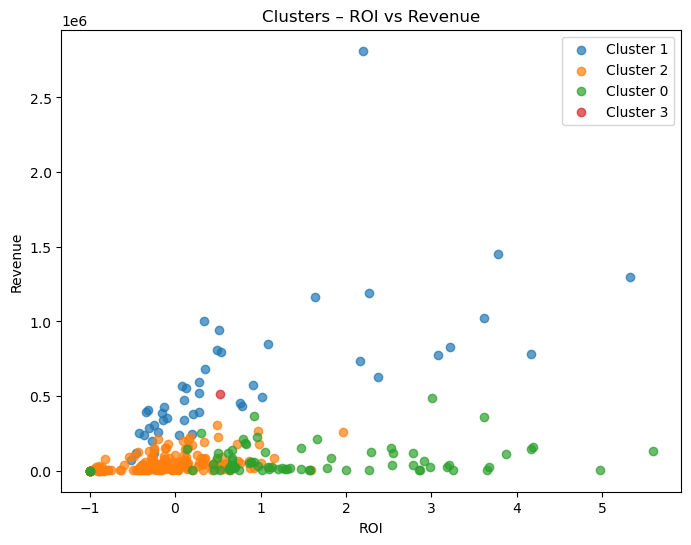

In [28]:
viz = clusters.select("roi","revenue","prediction").toPandas()

plt.figure(figsize=(8,6))
for c in viz["prediction"].unique():
    sub = viz[viz["prediction"] == c]
    plt.scatter(sub["roi"], sub["revenue"], label=f"Cluster {c}", alpha=0.7)

plt.xlabel("ROI")
plt.ylabel("Revenue")
plt.title("Clusters – ROI vs Revenue")
plt.legend()
plt.show()


#### **🔵 Bleu (Cluster 1) : ce sont les campagnes « machines à cash » — gros budget, gros chiffre d’affaires, ROI positif → à scaler en priorité.
#### 
#### 🟢 Vert (Cluster 0) : campagnes très rentables mais plus petites — pépites à développer intelligemment.
#### 
#### 🟠 Orange (Cluster 2) : campagnes qui brûlent du budget — faible chiffre d’affaires et ROI négatif → à couper ou repenser.
#### 
#### 🔴 Rouge (Cluster 3) : cas isolé, grosse campagne atypique — à analyser manuellement.**